# Build jsons for timed experiment

## Json format:

```
{

"level1":[
            {url:"url1", time: 100, label:"fake"},  # time in msec
            {url:"url2", time: 3000, label:"real"},
            
            ...
         ],
"level2":[
            {url:"url1", time: 100, label:"fake"},
            {url:"url2", time: 3000, label:"fake"},
            ...
            
         ],
"level3":[
            {url:"url1", time: 100, label:"real"},
            {url:"url2", time: 3000, label:"fake"},
            ...
            
         ]

.
.
.

}
```




## Structure of the jsons

- 50% real, 50% fake (balanced prevalence), but also 15% fake (low prevalence)
- Control the fakeness of deepfakes (work with elements that don't have obvious artifacts)
- Create versions with and without caricatures
- Same participant across different times
- Practice trials
- In each level, different times, but randomize order
- Balance the number of videos shown, number of times within a level, times shown per video
- Make sure we show caricatures and fakes an equal amount of times
- Mix both caricatures and deepfakes in one level

For practice trials:
- Start with longest time, decrease shown times and random at the end 
- Send the distribution of jsons

# Remaining tasks

- [ ] Ensure the number of times across levels is balanced
- [ ] Ensure the number of real/fakes across levels is balanced
- [ ] Measure the number of times we need to show each json to get around ~10 responses per video and per time

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import requests

In [3]:
# Load list of real deepfake URLs
def load_urls_from_jsons(json_folder):
    df_urls = set()
    for f in os.listdir(json_folder):
        if not f.endswith('.json'): continue
        j = json.load(open(os.path.join(json_folder,f)))
        for k in j.keys():
            for u in j[k]:
                df_urls.add(u)

    print("\nLoaded %d deepfake urls" % len(df_urls))

    return df_urls

deepfake_urls = load_urls_from_jsons('exp2_jsons')


Loaded 1015 deepfake urls


In [4]:
def build_label_dict(metadata_path='../metadata.json'):
    '''Checks metadata.json (in DeepfakeDetection main folder) to see if input f has a fake label. Returns true if it does.'''

    # Load metadata
    metadata = json.load(open(metadata_path))

    label_dict={}

    # Build label dict
    for part in metadata.values():
        for video, d in part.items():
            label_dict[video[:-4]] = d['label']
    
    return label_dict

def load_caricature_urls(base_url, label_dict):
    '''Loads all caricatures from a given base url. Returns a list of urls.'''

    urls = set()
    r = requests.get(base_url)
    # Loop over elements in caricature folder from visiongpu url
    for f in r.text.split('\n'):

        # Get the substring from f in between href=" and "
        f = f[f.find('href="')+6:f.find('"', f.find('href="')+6)]

        # Skip non mp4 files
        if not f.endswith('.mp4'): continue
        

        # if file corresponds to gradcam caricature with amp10:
        if 'cari' in f and 'gradcam_amp10' in f:
            # Check in metadata if f is a deepfake
            if label_dict[f.split('_')[0]]=='FAKE':
                urls.add(os.path.join(base_url,f))

    return urls
      
def load_real_urls(base_url, label_dict):
    '''Loads all real videos from a given base url. Returns a list of urls.'''

    urls = set()
    r = requests.get(base_url)
    # Loop over elements in caricature folder from visiongpu url
    for f in r.text.split('\n'):

        # Get the substring from f in between href=" and "
        f = f[f.find('href="')+6:f.find('"', f.find('href="')+6)]

        # Skip non mp4 files
        if not f.endswith('.mp4'): continue
        
        if label_dict.get(f[:-4], None)=='REAL':
                urls.add(os.path.join(base_url,f))

    return urls

label_dict = build_label_dict()
cari_urls = load_caricature_urls("http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/", label_dict)
real_urls = load_real_urls("http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/", label_dict)
print("%d cari_urls loaded" %len(cari_urls))
print("%d real urls loaded" %len(real_urls))

199 cari_urls loaded
200 real urls loaded


In [5]:
def get_fake_urls_from_cari_urls(cari_urls):
    '''Extracts the 10-character filename of each cari url and builds new url with it'''

    fake_urls = set()
    for url in cari_urls:
        fake_urls.add(url.split('_')[0]+'.mp4')

    return fake_urls

fake_urls = get_fake_urls_from_cari_urls(cari_urls)
print("%d fake urls loaded" % len(fake_urls))

199 fake urls loaded


In [6]:
def create_jsons_for_timed_experiment(real_urls, fake_urls, cari_urls, number_of_jsons_to_make, 
                                        pres_times, number_of_levels_per_json, number_of_elems_per_level):
    '''Creates a set of jsons assigning all real and fake urls to different jsons, 
    according to the number_of_elems_per_level and the number of levels per json.
    These jsons have:
    - Level 0: practice trial
    - In each level, each deepfake is shown for different times, but the order of those times is randomized
    - Balance the number of videos shown, number of times within a level, times shown per video
    - Make sure we show caricatures and fakes an equal amount of times
    - Mix both caricatures and deepfakes in one level, but have some elements without caricatures at all'''

    jsons = []

    print(len(real_urls), len(fake_urls), len(cari_urls))

    for i in range(number_of_jsons_to_make):

        # Create empty json
        j = {}

        # Every json must have a balanced number of real/fake, around 25% caricatures and 25% deepfakes, 
        # a balanced number of pres_times, and show each video only once. Across all jsons, we should have a balanced number of times per video 
        
    # # Generate random list of FAKE/REAL labels
    # real_fake = ["FAKE_OR_CARI","REAL"]*int(number_of_elems_per_level*number_of_levels_per_json/2 +1)
    # np.random.shuffle(real_fake)

    # # Generate random list of FAKE/CARI labels, half the size of the real_fake array
    # fake_cari = ["FAKE","CARI"]*int(len(real_fake)/2) 
    # np.random.shuffle(fake_cari)


        # Create list of REAL labels
        real_labels = ["REAL"]*int(np.ceil(number_of_elems_per_level*number_of_levels_per_json/2))

        # Create list of FAKE labels
        fake_labels = ["FAKE"]*int(np.ceil(number_of_elems_per_level*number_of_levels_per_json/4))

        # Create list of CARI labels
        cari_labels = ["CARI"]*int(np.ceil(number_of_elems_per_level*number_of_levels_per_json/4))

        # Concatenate the lists
        labels = real_labels + fake_labels + cari_labels
        np.random.shuffle(labels)

        # Generate random list of pres_times
        pres_times_list = pres_times*int(number_of_elems_per_level*number_of_levels_per_json/len(pres_times)/2 +1)
        np.random.shuffle(pres_times_list)

        # Ensure pres_times_list and labels are both larger than number_of_elems_per_level*number_of_levels_per_json
        assert(len(pres_times_list) >= number_of_elems_per_level*number_of_levels_per_json)
        assert(len(labels) >= number_of_elems_per_level*number_of_levels_per_json)

        # Create levels
        for l in range(number_of_levels_per_json):
            j["level%d"%l] = []
            
            # Add videos to level by popping for shuffled list of labels and pres_times
            for t in range(number_of_elems_per_level):

                # Assign urls to jsons
                if labels.pop()=="REAL":
                    j["level%d"%l].append({"url": real_urls.pop(), "time": pres_times_list.pop(), "label": 'REAL'})
                elif labels.pop()=="FAKE":
                    j["level%d"%l].append({"url": fake_urls.pop(), "time": pres_times_list.pop(), "label": 'FAKE'})
                else: # popped a cari token, add a caricature instead of a fake
                    j["level%d"%l].append({"url": cari_urls.pop(), "time": pres_times_list.pop(), "label": 'CARI'})

        save_json(j, "jsons/json_"+str(i)+".json")
        jsons.append(j)
    

    return jsons
            
def save_json(j, path):
    with open(path, 'w') as f:
        json.dump(j, f)



In [7]:
# Calculate the number of jsons needed to show all fakes and caris loaded

number_of_levels_per_json=5
number_of_elements_per_level=20
pres_times=[300, 500, 1000, 2000, 3000, 5000]
reps=1

number_of_jsons_to_make = int(np.ceil((len(fake_urls)+len(cari_urls))*len(pres_times)*reps/number_of_elements_per_level/number_of_levels_per_json/2))
print("For the given vars, the number of jsons needed to show all fakes and caris at least once for each time is: %d" % number_of_jsons_to_make)


print("len(real_urls)",len(real_urls))
print("len(fake_urls)",len(fake_urls))
print("len(fake_urls)",len(cari_urls))

timedexp_jsons = create_jsons_for_timed_experiment(real_urls.copy(), fake_urls.copy(), cari_urls.copy(), 
                                                    number_of_jsons_to_make=number_of_jsons_to_make, 
                                                    pres_times=pres_times, 
                                                    number_of_levels_per_json=number_of_levels_per_json, 
                                                    number_of_elems_per_level=number_of_elements_per_level)
print("%d jsons created" % len(timedexp_jsons))


For the given vars, the number of jsons needed to show all fakes and caris at least once for each time is: 12
len(real_urls) 200
len(fake_urls) 199
len(fake_urls) 199
200 199 199


IndexError: pop from empty list

In [9]:
np.ceil(3.7)

4.0

In [6]:
timedexp_jsons[0]

{'level0': [{'url': 'http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/syxobtuucp.mp4',
   'time': 1000,
   'label': 'REAL'},
  {'url': 'http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/blnmxntbey.mp4',
   'time': 500,
   'label': 'REAL'},
  {'url': 'http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/fjrueenjyp_cari_Small_gradcam_amp10.mp4',
   'time': 2000,
   'label': 'CARI'},
  {'url': 'http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/eqslzbqfea_cari_Small_gradcam_amp10.mp4',
   'time': 300,
   'label': 'CARI'},
  {'url': 'http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/tynfsthodx.mp4',
   'time': 2000,
   'label': 'FAKE'},
  {'url': 'http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/ipvwtgdlre_cari_Small_gradcam_amp10.mp4',
   'time': 2000,
   'label': 'CARI'},
  {'url': 'http://visiongpu23.csail.mit.e

In [1]:
# import requests

# response = requests.get('http://visiongpu23.csail.mit.edu/scratch/datasets/DeepfakeDetection/caricatures/')

# print(response.text)

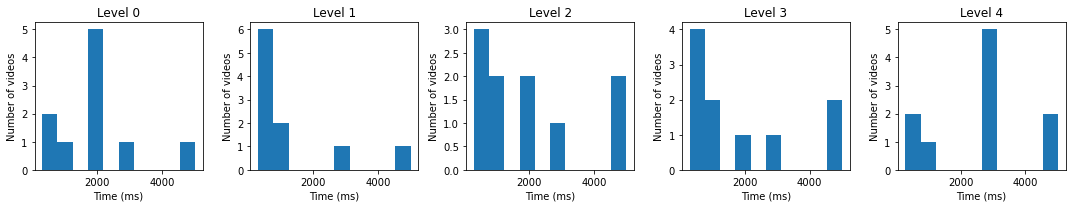

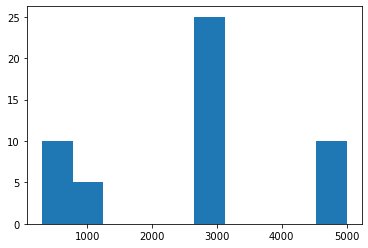

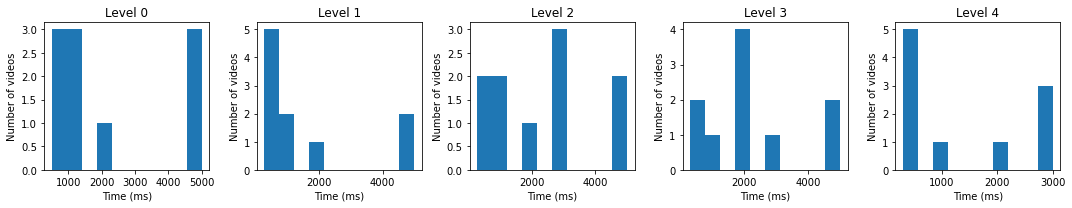

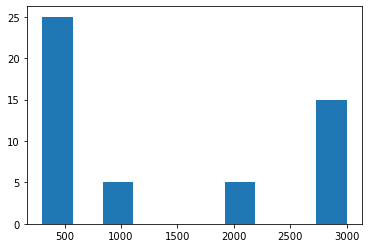

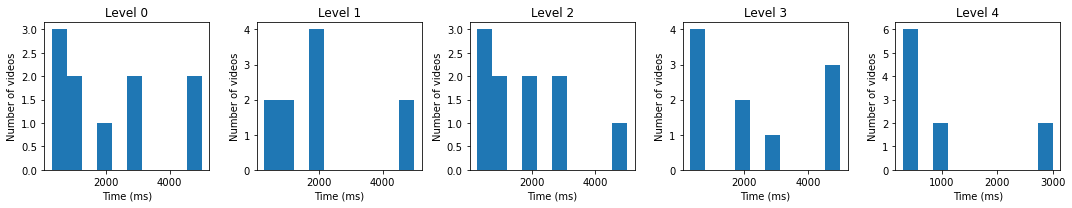

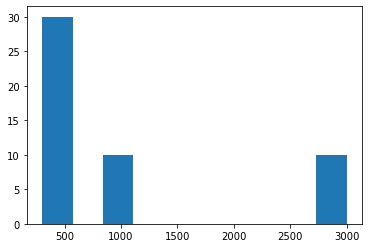

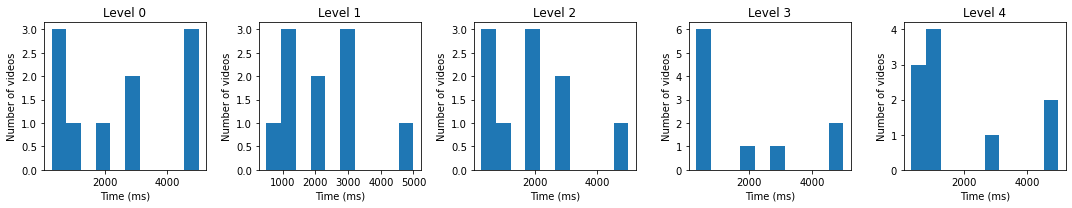

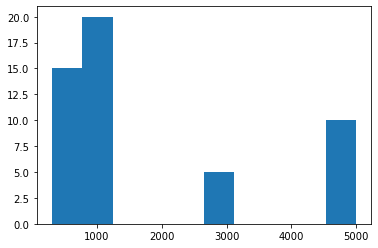

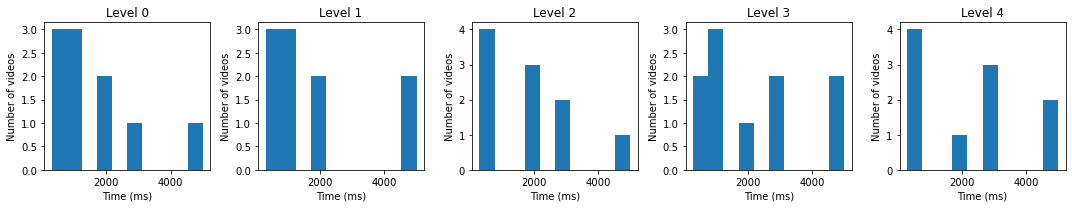

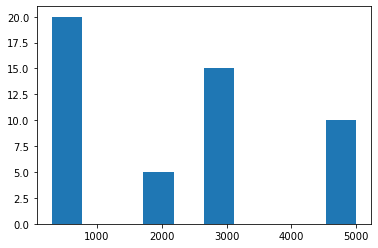

In [7]:
# Visualize the jsons

def vis_jsons(json):
    '''Plot histograms showing properties of given json: 
        1. Times in a level
        2. Proportion of reals and fakes
    '''

    number_of_levels = len(json)

    plt.figure(figsize=(15,3))
    for l in range(number_of_levels):
        plt.subplot(1, number_of_levels, l+1)
        plt.hist(np.array([x['time'] for x in json["level%d"%l]]))
        plt.title("Level %d"%l)
        plt.xlabel("Time (ms)")
        plt.ylabel("Number of videos")
        plt.tight_layout()
    plt.show()

    # Show barchart of times over the entire json
    plt.figure()   
    plt.hist(np.array([x['time'] for x in json["level%d"%l] for l in range(number_of_levels)]), bins = 10)
    plt.show()



vis_jsons(timedexp_jsons[0])
vis_jsons(timedexp_jsons[1])
vis_jsons(timedexp_jsons[2])
vis_jsons(timedexp_jsons[3])
vis_jsons(timedexp_jsons[4])

In [3]:
# Build Jsons

def build_json(urls, times):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-3-260ab8fb77e0>, line 4)